In [1]:
import numpy as np
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib inline

In [3]:
# comptomized and band spectra functions
# E is photon energy, A is normalization, E0 is pivot energy

def band_Elow_spec(E, A, alpha, beta, Epeak, E0):
    # A*((E/E0)**alpha)*exp[-(alpha+2)*E/Epeak]
    return A*((E/E0)**(alpha))*np.exp(-(alpha+2.0)*E/Epeak)

def band_Ehi_spec(E, A, alpha, beta, Epeak, E0):
    # A*((E/E0)**beta)*exp[beta-alpha]*((alpha-beta)*(Epeak/E0)/(alpha+2))**(alpha-beta)
    return A*((E/E0)**(beta))*np.exp(beta-alpha)*\
            ((alpha-beta)*(Epeak/E0)/(alpha+2.0))**(alpha-beta)

def band_spec(E, A, alpha, beta, Epeak, E0=100.0):
    '''
    Band spectra
    '''
    
    Ebreak = (alpha - beta)*Epeak/(alpha+2.0)
    if np.isscalar(E):
        if E < Ebreak:
            return band_Elow_spec(E, A, alpha, beta, Epeak, E0)
        else:
            return band_Ehi_spec(E, A, alpha, beta, Epeak, E0)
    low_inds = np.where((E<Ebreak))
    hi_inds = np.where((E>=Ebreak))
    spec = np.zeros_like(E)
    spec[low_inds] = band_Elow_spec(E[low_inds], A, alpha, beta, Epeak, E0)
    spec[hi_inds] = band_Ehi_spec(E[hi_inds], A, alpha, beta, Epeak, E0)
    return spec
    

def comp_spec(E, A, alpha, Epeak, E0=100.0):
    '''
    Comptomized spectra
    '''
    
    spec = A*((E/E0)**(alpha))*np.exp(-E*(2.+alpha)/Epeak)
    return spec


def get_comp_photon_fluxes(Elos, Ehis, A, alpha, Epeak, E0=100.0, Nsub_bins=10):
    '''
    Gets the photon flux (photons per cm2 per s) in a set of energy bins
    for a Comptomized spectra
    '''

    
    DeltaEs = Ehis - Elos
    NEs = len(Elos)
    
    fluxes = np.zeros(NEs)
    
    # loops over photon energy bins
    for i in range(NEs):
        
        Es = np.linspace(Elos[i], Ehis[i], Nsub_bins)
        dE = Es[1] - Es[0]
        # integrate spec*dE to get photon flux in bin
        fluxes[i] = np.sum(comp_spec(Es, A, alpha, Epeak, E0=E0))*dE
        
    return fluxes

def get_band_photon_fluxes(Elos, Ehis, A, alpha, beta, Epeak, E0=100.0, Nsub_bins=10):
    '''
    Gets the photon flux (photons per cm2 per s) in a set of energy bins
    for a Band spectra
    '''
    
    DeltaEs = Ehis - Elos
    NEs = len(Elos)
    
    fluxes = np.zeros(NEs)
    
    # loops over photon energy bins
    for i in range(NEs):
        
        Es = np.linspace(Elos[i], Ehis[i], Nsub_bins)
        dE = Es[1] - Es[0]
        # integrate spec*dE to get photon flux in bin
        fluxes[i] = np.sum(band_spec(Es, A, alpha, beta, Epeak, E0=E0))*dE
        
    return fluxes


def get_comp_rates(resp_mat, Elos, Ehis, A, alpha, Epeak, E0=100.0):
    '''
    Gets the expected rate count from a specific Comptomized spectra
    in each energy bin
    
    resp_mat: the DRM
    Elos: the low side of the Photon energy bins for the DRM
    Ehis: the high side of the Photon energy bins for the DRM
    A: spectral norm 
    alpha: alpha
    Epeak: Epeak (keV)
    
    returns:
    rates: array with a length of the number of energy bins in resp_mat
    
    '''
    
    # get photon flux in each photon energy bin
    fluxes = get_comp_photon_fluxes(Elos, Ehis, A, alpha, Epeak, E0=E0)
    # multiply DRM by photon fluxes and sum over photon energy axis
    rates = np.sum(resp_mat*fluxes[:,np.newaxis], axis=0)
    return rates

def get_comp_eflux(Emin, Emax, A, alpha, Epeak, E0=100.0, Nbins=int(1e4)):
    '''
    Gets the energy flux from a specific Comptomized spectra from Emin to Emax
    
    Emin: the low bound of the energy flux
    Emax: the high bound of the energy flux
    A: spectral norm 
    alpha: alpha
    Epeak: Epeak (keV)
    
    returns:
    flux: float (erg / cm2 / s)
    
    '''
    
    Es = np.linspace(Emin, Emax, int(Nbins))
    dE = Es[1] - Es[0]
    kev2erg = 1.60218e-9
    # integrate spectra*E*dE to get energy flux and convert to erg
    flux = np.sum(comp_spec(Es, A, alpha, Epeak, E0=E0)*Es)*dE*kev2erg
    return flux

def rate2comp_eflux(rate, resp_mat, Elos, Ehis, alpha, Epeak, Emin, Emax):
    '''
    Returns the flux from a specific Comptomized spectra that would result in 
    an expected rate count (summed over all energy bins) of rate
    
    rate: total rate counts across energy bins
    resp_mat: the DRM
    Elos: the low side of the Photon energy bins for the DRM
    Ehis: the high side of the Photon energy bins for the DRM
    A: spectral norm 
    alpha: alpha
    Epeak: Epeak (keV)
    Emin: the low bound of the energy flux
    Emax: the high bound of the energy flux
    
    returns:
    flux: float (erg / cm2 / s)
    
    '''
    
    # first get what the rate would be given A=1
    rates_norm = get_comp_rates(resp_mat, Elos, Ehis, 1.0, alpha, Epeak)
    rate_norm = np.sum(rates_norm)
    # Then A can be solved from A/A_norm = rate / rate_norm
    # where A is the spec norm for the flux that creates "rate" counts
    A = rate / rate_norm
    flux = get_comp_eflux(Emin, Emax, A, alpha, Epeak)
    return flux

In [4]:
def get_band_rates(resp_mat, Elos, Ehis, A, alpha, beta, Epeak, E0=100.0):
    '''
    Gets the expected rate count from a specific BAND spectra
    in each energy bin
    
    resp_mat: the DRM
    Elos: the low side of the Photon energy bins for the DRM
    Ehis: the high side of the Photon energy bins for the DRM
    A: spectral norm 
    alpha: alpha
    beta: beta
    Epeak: Epeak (keV)
    
    returns:
    rates: array with a length of the number of energy bins in resp_mat
    
    '''
    
    # get photon flux in each photon energy bin
    fluxes = get_band_photon_fluxes(Elos, Ehis, A, alpha, beta, Epeak, E0=E0)
    # multiply DRM by photon fluxes and sum over photon energy axis
    rates = np.sum(resp_mat*fluxes[:,np.newaxis], axis=0)
    return rates

def get_band_eflux(Emin, Emax, A, alpha, beta, Epeak, E0=100.0, Nbins=int(1e4)):
    '''
    Gets the energy flux from a specific Band spectra from Emin to Emax
    
    Emin: the low bound of the energy flux
    Emax: the high bound of the energy flux
    A: spectral norm 
    alpha: alpha
    beta: beta
    Epeak: Epeak (keV)
    
    returns:
    flux: float (erg / cm2 / s)
    
    '''
    
    Es = np.linspace(Emin, Emax, int(Nbins))
    dE = Es[1] - Es[0]
    kev2erg = 1.60218e-9
    # integrate spectra*E*dE to get energy flux and convert to erg
    flux = np.sum(band_spec(Es, A, alpha, beta, Epeak, E0=E0)*Es)*dE*kev2erg
    return flux

def rate2band_eflux(rate, resp_mat, Elos, Ehis, alpha, beta, Epeak, Emin, Emax):
    '''
    Returns the flux from a specific Band spectra that would result in 
    an expected rate count (summed over all energy bins) of rate
    
    rate: total rate counts across energy bins
    resp_mat: the DRM
    Elos: the low side of the Photon energy bins for the DRM
    Ehis: the high side of the Photon energy bins for the DRM
    A: spectral norm 
    alpha: alpha
    beta: beta
    Epeak: Epeak (keV)
    Emin: the low bound of the energy flux
    Emax: the high bound of the energy flux
    
    returns:
    flux: float (erg / cm2 / s)
    
    '''
    
    # first get what the rate would be given A=1
    rates_norm = get_band_rates(resp_mat, Elos, Ehis, 1.0, alpha, beta, Epeak)
    rate_norm = np.sum(rates_norm)
    # Then A can be solved from A/A_norm = rate / rate_norm
    # where A is the spec norm for the flux that creates "rate" counts
    A = rate / rate_norm
    flux = get_band_eflux(Emin, Emax, A, alpha, beta, Epeak)
    return flux

In [5]:
# change these paths to where your response files are

import os
cwd = os.getcwd()

drm_dir_old = cwd+'/rsp_maskweight'
drm_dir_nitrates = cwd+'/rsp_NITRATES/'

def get_drm_tab(grid_id, old=False, get_ebounds=False):
    
    num_str = str(grid_id)
    if len(num_str) < 2:
        num_str = '0' + num_str
    
    if old:
        drm_fname = os.path.join(drm_dir_old, 'BAT_alldet_grid_%s.rsp'%(num_str))        
        
    else:
        drm_fname = os.path.join(drm_dir_nitrates, 'BAT_alldet_grid_%s.rsp'%(num_str))
        
    drm_tab = Table.read(drm_fname)
    if get_ebounds:
        ebounds_tab = Table.read(drm_fname, hdu=2)
        return drm_tab, ebounds_tab
    return drm_tab

In [6]:
# band spec shape params
alpha = -1.0
beta = -2.3
Epeak = 230.0

# flux integration bounds
flux_elo = 15.0
flux_ehi = 350.0

In [7]:
Ndets_tot = 32768.0 # total dets
Ndets_active = 18000.0 # current number of active dets
Ndet_ratio = Ndets_active / Ndets_tot
Ndet_ratio = 1

rate_std = 145.0 # the std of rates from the LC
rate_upper_limit = 5*rate_std
print("5sigma rate upper limit: ", rate_upper_limit)

grid_id = 17

print("grid_id: ", grid_id)

# using energy bin 15-350 and ignoring 350-500
chan_low = 0 
chan_hi = 3

# getting the NITRATES DRM table
drm_tab = get_drm_tab(grid_id)

# response matrix using selected energy bins and corrected for number of active dets
drm_matrix = drm_tab['MATRIX'][:,chan_low:(chan_hi+1)]*Ndet_ratio 

# find the flux that gives an expected rate equal to the rate upper limit
flux_upper_limit = rate2band_eflux(rate_upper_limit, drm_matrix,\
                                   drm_tab['ENERG_LO'], drm_tab['ENERG_HI'],\
                                   alpha, beta, Epeak, flux_elo, flux_ehi)
print("Nitrates response")
print("5sigma flux upper limit: ", flux_upper_limit)

5sigma rate upper limit:  725.0
grid_id:  17
Nitrates response
5sigma flux upper limit:  3.743442212750468e-08


In [8]:

# using energy bin 14-194.9
chan_low_old = 3
chan_hi_old = 78

# getting the old DRM table
drm_tab_old = get_drm_tab(grid_id, old=True)

# response matrix using selected energy bins and corrected for number of active dets
drm_matrix = drm_tab_old['MATRIX'][:,chan_low_old:(chan_hi_old+1)]*Ndet_ratio 

# find the flux that gives an expected rate equal to the rate upper limit
flux_upper_limit = rate2band_eflux(rate_upper_limit, drm_matrix,\
                                   drm_tab_old['ENERG_LO'], drm_tab_old['ENERG_HI'],\
                                   alpha, beta, Epeak, flux_elo, flux_ehi)
print("Old response")
print("5sigma flux upper limit: ", flux_upper_limit)

Old response
5sigma flux upper limit:  4.4091263388170386e-08


In [9]:
grid_id = 14

print("grid_id: ", grid_id)

chan_low = 0
chan_hi = 3

drm_tab = get_drm_tab(grid_id)

# response matrix using selected energy bins and corrected for number of active dets
drm_matrix = drm_tab['MATRIX'][:,chan_low:(chan_hi+1)]*Ndet_ratio 

# find the flux that gives an expected rate equal to the rate upper limit
flux_upper_limit = rate2band_eflux(rate_upper_limit, drm_matrix,\
                                   drm_tab['ENERG_LO'], drm_tab['ENERG_HI'],\
                                   alpha, beta, Epeak, flux_elo, flux_ehi)
print("Nitrates response")
print("5sigma flux upper limit: ", flux_upper_limit)

grid_id:  14
Nitrates response
5sigma flux upper limit:  1.7190842147854627e-07


In [10]:

chan_low_old = 3
chan_hi_old = 78

drm_tab_old = get_drm_tab(grid_id, old=True)

# response matrix using selected energy bins and corrected for number of active dets
drm_matrix = drm_tab_old['MATRIX'][:,chan_low_old:(chan_hi_old+1)]*Ndet_ratio 

# find the flux that gives an expected rate equal to the rate upper limit
flux_upper_limit = rate2band_eflux(rate_upper_limit, drm_matrix,\
                                   drm_tab_old['ENERG_LO'], drm_tab_old['ENERG_HI'],\
                                   alpha, beta, Epeak, flux_elo, flux_ehi)
print("Old response")
print("5sigma flux upper limit: ", flux_upper_limit)

Old response
5sigma flux upper limit:  9.311813949417607e-07


grid_id:  17


Text(0.5, 1.0, 'Grid ID 17')

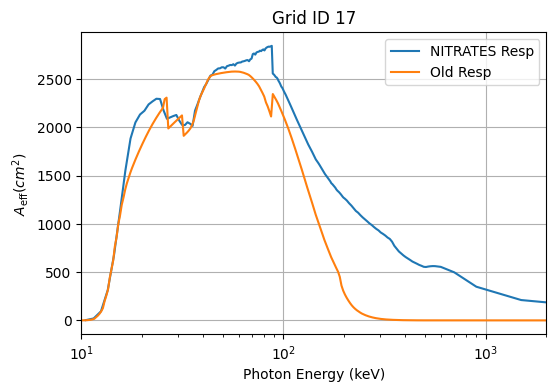

In [11]:
# plotting the effective Area 
grid_id = 17
print("grid_id: ", grid_id)

plt.figure(dpi=100)
# getting the NITRATES DRM table
drm_tab = get_drm_tab(grid_id)
# response matrix using selected energy bins and corrected for number of active dets
drm_matrix = drm_tab['MATRIX'][:,chan_low:(chan_hi+1)]*Ndet_ratio 
photon_Es = (drm_tab['ENERG_LO'] + drm_tab['ENERG_HI'])/2.
Aeff = np.sum(drm_matrix, axis=1) # summing Aeff over energy bins for each photon Energy

plt.plot(photon_Es, Aeff, label='NITRATES Resp')

drm_tab_old = get_drm_tab(grid_id, old=True)
# response matrix using selected energy bins and corrected for number of active dets
drm_matrix_old = drm_tab_old['MATRIX'][:,chan_low_old:(chan_hi_old+1)]*Ndet_ratio 
photon_Es_old = (drm_tab_old['ENERG_LO'] + drm_tab_old['ENERG_HI'])/2.
Aeff_old = np.sum(drm_matrix_old, axis=1) # summing Aeff over energy bins for each photon Energy

plt.plot(photon_Es_old, Aeff_old, label='Old Resp')

plt.grid(True)
plt.xscale('log')
plt.xlim(1e1, 2e3)
plt.xlabel('Photon Energy (keV)')
plt.ylabel(r'$A_{\rm eff} (cm^2)$ ')
plt.legend()
plt.title(r'Grid ID %d'%(grid_id))

grid_id:  14


Text(0.5, 1.0, 'Grid ID 14')

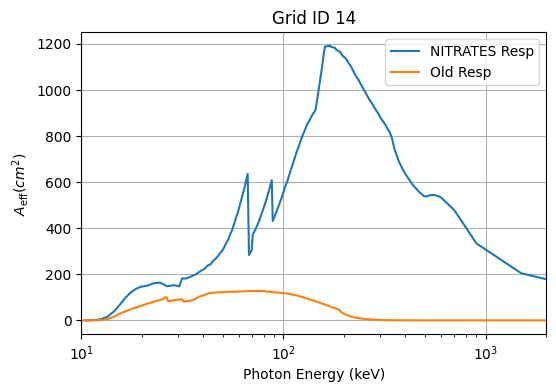

In [12]:
# plotting the effective Area 

grid_id = 14
print("grid_id: ", grid_id)

plt.figure(dpi=100)
# getting the NITRATES DRM table
drm_tab = get_drm_tab(grid_id)
# response matrix using selected energy bins and corrected for number of active dets
drm_matrix = drm_tab['MATRIX'][:,chan_low:(chan_hi+1)]*Ndet_ratio 
photon_Es = (drm_tab['ENERG_LO'] + drm_tab['ENERG_HI'])/2.
Aeff = np.sum(drm_matrix, axis=1) # summing Aeff over energy bins for each photon Energy

plt.plot(photon_Es, Aeff, label='NITRATES Resp')

drm_tab_old = get_drm_tab(grid_id, old=True)
# response matrix using selected energy bins and corrected for number of active dets
drm_matrix_old = drm_tab_old['MATRIX'][:,chan_low_old:(chan_hi_old+1)]*Ndet_ratio 
photon_Es_old = (drm_tab_old['ENERG_LO'] + drm_tab_old['ENERG_HI'])/2.
Aeff_old = np.sum(drm_matrix_old, axis=1) # summing Aeff over energy bins for each photon Energy

plt.plot(photon_Es_old, Aeff_old, label='Old Resp')

plt.grid(True)
plt.xscale('log')
plt.xlim(1e1, 2e3)
plt.xlabel('Photon Energy (keV)')
plt.ylabel(r'$A_{\rm eff} (cm^2)$ ')
plt.legend()
plt.title(r'Grid ID %d'%(grid_id))